# Calculating an exponentially weighted mean and statistics


## Import necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sowfadict as sowfa
import tools
from scipy.stats import norm
from scipy.stats import skew,kurtosis
from scipy import signal
import pandas as pd
from matplotlib.colors import Normalize

### Declare user variables (cases, towers, colors, etc.) for tower data

In [353]:
terrstr = 'SR'
simstr  = ['PGx2.2En4_zi550']*3

caselbl = ['Turb.','Laminar','Pert.']
cases   = ['M2_{}_TurbBC'.format(terrstr)]#,'M2_{}_NoTurbBC'.format(terrstr),'M2_{}_PertBC'.format(terrstr)]
if terrstr == 'SR':
    casec   = ['navy','darkturquoise','blue']
    terrstr_f = 'Complex Terrain'
elif terrstr == 'D2':
    casec   = ['red','goldenrod','darkred']
    terrstr_f = 'Smoothed Terrain'
casece  = [casec[0],'none',casec[2]]#,'none']
casecf  = ['none',casec[1],'none']#,casec[3]]
casem   = ['o','x','+']
caselw  = ['3','2','3','2']
casea   = [0.8,1.0,0.8,1.0]
casesz  = [50,15,50,15]
casels  = ['-',':','--']
ncases  = np.shape(cases)[0]

#simstr  = ['PGx2.2En4_zi550','PGx2.2En4_zi550','PGx2.2En4_zi550']#,'PGx2.2En4_zi550']
x = np.arange(0,101)

varns   = ['u','v','w','T']
nvars   = np.shape(varns)[0]

timedir = 14400

avgstart = 1799 # when do you want to start the averaging?
avgend   = -1 # when do you want to end the averaging?

lvl     = 5

twrs    = np.arange(1,9)
ntwrs   = np.shape(twrs)[0]

lblsize = 14.0
txtsize = 12.0
legsize = 10.0
savedir = '/home/phawbeck/SOWFA/Terrain/img/'


### Load in the data and store for manipulation & plotting

In [355]:
initIndividualTowerVars = True
initAvgTowerVars        = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        fdir      = '/projects/mmc/NWTCRegion/{}/NWTC.run.{}/postProcessing/'.format(simstr[cc],cases[cc])
        pl        = 'probeLine{}'.format(twrs[tt])
        probeLine = sowfa.probeLine('{}{}/{}/'.format(fdir,pl,timedir),'y',['U','T'])
        dt        = np.round(np.mean(probeLine.time[1:] - probeLine.time[:-1]),2)
        ntwr      = probeLine.ntowers; ntwrsq = int(np.sqrt(ntwr))
        if tt == 0: 
            tdz        = np.mean(probeLine.z[0,1:] - probeLine.z[0,:-1]) 
            twrheight  = probeLine.z[0,:] - probeLine.z[0,0] + tdz/2.0
            nz = np.shape(twrheight)[0]
        for vv in range(0,nvars):
            var = varns[vv]
            for tw in np.arange(0,probeLine.ntowers):
                if var == 'u':
                    pvar   = probeLine.u[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.u[tw,:,avgstart:avgend],axis=1)
                elif var == 'v':
                    pvar   = probeLine.v[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.v[tw,:,avgstart:avgend],axis=1)
                elif var == 'w':
                    pvar   = probeLine.w[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.w[tw,:,avgstart:avgend],axis=1)
                elif var == 'T':
                    pvar   = probeLine.T[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.T[tw,:,avgstart:avgend],axis=1)
                if initIndividualTowerVars == True:
                    print ("initializing individual tower vars")
                    time       = probeLine.time[avgstart:avgend] 
                    ntimes     = np.shape(time)[0]
                    tsvarfull  = np.zeros((nvars,ncases,ntwrs,ntwr,nz,ntimes))
                    initIndividualTowerVars = False
                tsvarfull[vv,cc,tt,tw,:,:]  = pvar
    print ('Done with case: {}'.format(cases[cc]))

initializing individual tower vars


ValueError: could not broadcast input array from shape (75,4826) into shape (75,4825)

In [352]:
print(probeLine.time)

[14401. 14402. 14403. ... 30598. 30599. 30600.]


## Exponentially weighted mean

In [8]:
towerlines = np.asarray([1,3,5,7])-1
n_twrlines = len(towerlines)

In [ ]:
statistics_start_time = 3600
nt    = np.shape(u)[-1]
window_len = 0.15
#alpha = np.exp(-(dt**(nt+1))/window_len)
#alpha   = 210/(nt+1)
#alpha_2 = 60/(nt+1)

alpha   = 70/(nt+1)
alpha_2 = 12/(nt+1)

avg_u_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_u_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

avg_v_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_v_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

avg_w_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_w_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

up_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
up_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

vp_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
vp_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

wp_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
wp_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

var_u_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
var_u_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

var_v_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
var_v_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

var_w_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
var_w_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))

avg_var_u_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_var_u_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_var_u_runexp = np.zeros((ncases,ntwrs,ntwr,nz,nt))

avg_var_v_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_var_v_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_var_v_runexp = np.zeros((ncases,ntwrs,ntwr,nz,nt))

avg_var_w_exp = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_var_w_run = np.zeros((ncases,ntwrs,ntwr,nz,nt))
avg_var_w_runexp = np.zeros((ncases,ntwrs,ntwr,nz,nt))

#nt = 5200
for cc in range(0,ncases):
    u = tsvarfull[varns.index('u'),cc,:,:,:,:]
    v = tsvarfull[varns.index('v'),cc,:,:,:,:]
    w = tsvarfull[varns.index('w'),cc,:,:,:,:]
    avg_u_exp[cc,:,:,:,0] = u[:,:,:,0]
    avg_u_run[cc,:,:,:,0] = u[:,:,:,0]
    avg_v_exp[cc,:,:,:,0] = v[:,:,:,0]
    avg_v_run[cc,:,:,:,0] = v[:,:,:,0]
    avg_w_exp[cc,:,:,:,0] = w[:,:,:,0]
    avg_w_run[cc,:,:,:,0] = w[:,:,:,0]


    init_avg_stats = True
    for tt in range(1,nt):
        avg_u_exp[cc,:,:,:,tt] = avg_u_exp[cc,:,:,:,tt-1] + alpha*(u[:,:,:,tt]-avg_u_exp[cc,:,:,:,tt-1])
        avg_u_run[cc,:,:,:,tt] = np.mean(u[:,:,:,:tt],axis=3)
        
        avg_v_exp[cc,:,:,:,tt] = avg_v_exp[cc,:,:,:,tt-1] + alpha*(v[:,:,:,tt]-avg_v_exp[cc,:,:,:,tt-1])
        avg_v_run[cc,:,:,:,tt] = np.mean(v[:,:,:,:tt],axis=3)
        
        avg_w_exp[cc,:,:,:,tt] = avg_w_exp[cc,:,:,:,tt-1] + alpha*(w[:,:,:,tt]-avg_w_exp[cc,:,:,:,tt-1])
        avg_w_run[cc,:,:,:,tt] = np.mean(w[:,:,:,:tt],axis=3)
        
        if tt >= statistics_start_time:
            up_exp[cc,:,:,:,tt] = u[:,:,:,tt]-avg_u_exp[cc,:,:,:,tt-1]
            up_run[cc,:,:,:,tt] = u[:,:,:,tt]-avg_u_run[cc,:,:,:,tt-1]
            
            vp_exp[cc,:,:,:,tt] = v[:,:,:,tt]-avg_v_exp[cc,:,:,:,tt-1]
            vp_run[cc,:,:,:,tt] = v[:,:,:,tt]-avg_v_run[cc,:,:,:,tt-1]
            
            wp_exp[cc,:,:,:,tt] = w[:,:,:,tt]-avg_w_exp[cc,:,:,:,tt-1]
            wp_run[cc,:,:,:,tt] = w[:,:,:,tt]-avg_w_run[cc,:,:,:,tt-1]

            var_u_exp[cc,:,:,:,tt] = up_exp[cc,:,:,:,tt]**2
            var_u_run[cc,:,:,:,tt] = up_run[cc,:,:,:,tt]**2
            
            var_v_exp[cc,:,:,:,tt] = vp_exp[cc,:,:,:,tt]**2
            var_v_run[cc,:,:,:,tt] = vp_run[cc,:,:,:,tt]**2
            
            var_w_exp[cc,:,:,:,tt] = wp_exp[cc,:,:,:,tt]**2
            var_w_run[cc,:,:,:,tt] = wp_run[cc,:,:,:,tt]**2

            if tt >= statistics_start_time+1:

                avg_var_u_exp[cc,:,:,:,tt] = avg_var_u_exp[cc,:,:,:,tt-1] + \
                                          alpha_2*(var_u_exp[cc,:,:,:,tt]-avg_var_u_exp[cc,:,:,:,tt-1])
                avg_var_u_runexp[cc,:,:,:,tt] = np.mean(var_u_exp[cc,:,:,:,statistics_start_time:tt],axis=3)
                avg_var_u_run[cc,:,:,:,tt] = np.mean(var_u_run[cc,:,:,:,statistics_start_time:tt],axis=3)
                
                avg_var_v_exp[cc,:,:,:,tt] = avg_var_v_exp[cc,:,:,:,tt-1] + \
                                          alpha_2*(var_v_exp[cc,:,:,:,tt]-avg_var_v_exp[cc,:,:,:,tt-1])
                avg_var_v_runexp[cc,:,:,:,tt] = np.mean(var_v_exp[cc,:,:,:,statistics_start_time:tt],axis=3)
                avg_var_v_run[cc,:,:,:,tt] = np.mean(var_v_run[cc,:,:,:,statistics_start_time:tt],axis=3)
                
                avg_var_w_exp[cc,:,:,:,tt] = avg_var_w_exp[cc,:,:,:,tt-1] + \
                                          alpha_2*(var_w_exp[cc,:,:,:,tt]-avg_var_w_exp[cc,:,:,:,tt-1])
                avg_var_w_runexp[cc,:,:,:,tt] = np.mean(var_w_exp[cc,:,:,:,statistics_start_time:tt],axis=3)
                avg_var_w_run[cc,:,:,:,tt] = np.mean(var_w_run[cc,:,:,:,statistics_start_time:tt],axis=3)
    print ('Done with case: {}'.format(cases[cc]))

## Mean:

In [9]:
print(towerlines)

[0 2 4 6]


In [ ]:
fig,ax = plt.subplots(nrows=ntwr, ncols=n_twrlines, figsize=(12,12),sharex=True,sharey=True)
for tl in range(0,n_twrlines):
    for tw in range(0,ntwr):
        ax[tw,tl].plot(time/3600.0,u[tl,tw,lvl,:],c='k',alpha=1.0,label='raw data')
        ax[tw,tl].plot(time/3600.0,avg_u_exp[cc,tl,tw,lvl,:],c='r',alpha=1.0,label='exp. weighted')
        ax[tw,tl].plot(time/3600.0,avg_u_run[cc,tl,tw,lvl,:],c='g',alpha=1.0,label='running mean')
        #ax[tw].set_ylim(7.0,8.0)
        ax[tw,tl].tick_params(labelsize=12)
        #ax[tw,tl].set_xlim(8.26,8.35)
        ax[tw,tl].set_xlim(min(time)/3600.0,max(time)/3600.0)
ax[4,0].set_ylabel('u-Component wind speed [m s$^{-1}$]',size=15)
ax[0,0].legend(frameon=False,ncol=3,fontsize=14,loc=(0.0,1.0))
plt.suptitle('Averages over time',size=15,y=0.93)
plt.show()

## Variance:

In [ ]:
fig,ax = plt.subplots(nrows=ntwr, ncols=n_twrlines, figsize=(12,12),sharex=True,sharey=True)
lvl = 5
cc  = 1
for tt,tl in enumerate(towerlines):
#for tl in range(0,n_twrlines):
    for tw in range(0,ntwr):
        #ax[tw,tl].plot(time/3600.0,u[tl,tw,:],c='k',alpha=1.0,label='raw data')
        ax[tw,tt].plot(time/3600.0,var_u_exp[cc,tl,tw,lvl,:],c='r',alpha=0.5,
                       label='Variance | exp. w. mean (V-EWM)')
        ax[tw,tt].plot(time/3600.0,var_u_run[cc,tl,tw,lvl,:],c='g',alpha=0.5,
                       label='Variance | running mean')
        ax[tw,tt].plot(time/3600.0,avg_var_u_runexp[cc,tl,tw,lvl,:],c='b',alpha=1.0,lw=2.0,
                       label='running mean of V-EWM')
        ax[tw,tt].plot(time/3600.0,avg_var_u_exp[cc,tl,tw,lvl,:],c='k',alpha=0.8,
                       label='exp. w. mean of V-EWM')

        ax[tw,tt].set_ylim(-0.50,5.0)
        ax[tw,tt].tick_params(labelsize=12)
        #ax[tw,tl].set_xlim(8.35,8.4)
        ax[tw,tt].set_xlim(min(time)/3600.0,max(time)/3600.0)
ax[4,0].set_ylabel('Variance-u [m$^2$ s$^{-2}$]',size=15)
ax[0,0].legend(frameon=False,ncol=2,fontsize=14,loc=(0.0,1.0))
plt.suptitle('Variance over time',size=15,y=0.95)
plt.show()

# Average Variance

In [ ]:
c = 1
fig,ax = plt.subplots(nrows=ntwr, ncols=n_twrlines, figsize=(12,12),sharex=True,sharey=True)
for tl in range(0,n_twrlines):
    for tw in range(0,ntwr):
        #ax[tw,tl].plot(time/3600.0,u[tl,tw,:],c='k',alpha=1.0,label='raw data')
        ax[tw,tl].plot(time/3600.0,avg_var_u_exp[cc,tl,tw,lvl,:],c='darkred',alpha=1.0,label='exp. w. mean of Variance | exp. w. mean')
        ax[tw,tl].plot(time/3600.0,avg_var_u_runexp[cc,tl,tw,lvl,:],c='b',alpha=1.0,label='running mean of Variance | exp. w. mean')
        ax[tw,tl].set_ylim(0.0,3.0)
        ax[tw,tl].tick_params(labelsize=12)
        #ax[tw,tl].set_xlim(8.26,8.35)
        ax[tw,tl].set_xlim(min(time)/3600.0,max(time)/3600.0)
ax[4,0].set_ylabel('Variance-u [m$^2$ s$^{-2}$]',size=15)
ax[0,0].legend(frameon=False,ncol=3,fontsize=14,loc=(0.0,1.0))
plt.suptitle('Averaged variance over time',size=15,y=0.93)
plt.show()

In [ ]:
cc = 2
fig,ax = plt.subplots(nrows=ncases, ncols=4, sharey=True, sharex=True, figsize=(16,5))
for cc in range(0,ncases):
    for tl in range(0,n_twrlines):
        ax[cc,tl].plot(time/3600.0,np.mean(var_u_exp[cc,tl,:,lvl,:],axis=0),c='k',alpha=0.3,
                    label='avg variance (from EWM) along towers')
        ax[cc,tl].plot(time/3600.0,np.mean(avg_var_u_exp[cc,tl,:,lvl,:],axis=0),c='darkred',alpha=1.0,
                    label='avg. EWM of EWM of variance')
        ax[cc,tl].plot(time/3600.0,np.mean(avg_var_u_runexp[cc,tl,:,lvl,:],axis=0),c='blue',alpha=1.0,
                    label='avg. running mean of EWM of variance')
        ax[cc,tl].plot(time/3600.0,np.mean(avg_var_u_run[cc,tl,:,lvl,:],axis=0),c='darkgreen',alpha=1.0,
                    label='avg. orignal variance')
        ax[cc,tl].set_ylim(0,2.5)
        ax[cc,tl].tick_params(labelsize=12.0)
    ax[cc,0].text(4.5,2.3,cases[cc].replace('M2_D2_',''),ha='left',va='top',size=14)
    
ax[0,0].legend(frameon=False,ncol=4, loc=(0.1,1.01))
plt.show()

In [ ]:
tke_pct1 = np.mean(avg_var_u_runexp[1,:,:,:,-1]/avg_var_u_runexp[0,:,:,:,-1],axis=1)
tke_pct2 = np.mean(avg_var_u_runexp[2,:,:,:,-1]/avg_var_u_runexp[0,:,:,:,-1],axis=1)
plt.subplot(211)
plt.pcolormesh(tke_pct1.T)
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(tke_pct2.T)
plt.colorbar()
plt.show()

### Calculate statistics

In [ ]:
saveFig = False
var = 'u'
varind = varns.index(var)
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(9,8),sharex=True)
if var == 'T':
    plt.suptitle('Potential Temperature [K]',size=lblsize)
    labelstr = '[K]'
    legloc = 4
else:
    plt.suptitle('{}-component Wind Speed\n{} - {}'.format(var,simstr[0],terrstr_f),size=lblsize)
    labelstr = '[m s$^{-1}$]'
    legloc = (0.01,1.02)

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)
ax[3].tick_params(labelsize=14)
for cc in range(0,ncases):
    lw = 2.0; ms = 125
    if cc > 0: lw = 3.0; ms = 130
    ax[0].scatter(twrs,vmean[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw,label=caselbl[cc])
    ax[1].scatter(twrs,vvari[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw)
    ax[2].scatter(twrs,vskew[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw)
    ax[3].scatter(twrs,vkurt[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw)
ax[0].legend(frameon=False,ncol=ncases,loc=(0.01,1.02),fontsize=12)
ax[0].set_ylabel('Mean',size=14)
ax[1].set_ylabel('Variance',size=14)
ax[2].set_ylabel('Skewness',size=14)
ax[3].set_ylabel('Kurtosis',size=14)
ax[3].set_xlabel('Tower Number',size=14)
if saveFig: 
    plt.savefig('{}{}_{}_Statistics_{}.png'.format(savedir,simstr[cc].replace('.','p'),terrstr,var))
    plt.savefig('{}{}_{}_Statistics_{}.pdf'.format(savedir,simstr[cc].replace('.','p'),terrstr,var))
plt.show()

In [ ]:
series = [1, 1, 2, 2, 3, 3, 4, 4]

sum(series)/len(series)
running_mean  = np.zeros((len(series)))
running_mean2 = np.zeros((len(series)))

running_mean[0]  = series[0]
running_mean2[0] = series[0]
alpha = 0.8#/(len(series)-1)

for tt in range(1,len(series)):
    running_mean[tt]  = running_mean[tt-1] + alpha*(series[tt] - running_mean[tt-1])
    running_mean2[tt] = np.mean(series[:tt])
    print(running_mean2[tt])

plt.plot(series)
plt.axhline(2.5,c='k')
plt.plot(running_mean,c='b')
plt.plot(running_mean2,c='g')

# Testing the weights:

In [258]:
statistics_start_time = 3600

cc = 1
u = tsvarfull[varns.index('u'),cc,towerlines,:,5,:]

nt    = np.shape(u)[-1]
window_len = 0.18
#alpha   = 70/(nt+1)
alpha = 1.0 - np.exp(-dt/600.0)

alpha_2 = 12/(nt+1)


avg_u_expT = np.zeros((n_twrlines,ntwr,nt))
up_expT = np.zeros((n_twrlines,ntwr,nt))
var_u_expT = np.zeros((n_twrlines,ntwr,nt))
avg_var_u_expT = np.zeros((n_twrlines,ntwr,nt))
avg_var_u_runexpT = np.zeros((n_twrlines,ntwr,nt))

avg_u_expT[:,:,0] = u[:,:,0]

init_avg_stats = True
for tt in range(1,nt):
    avg_u_expT[:,:,tt] = avg_u_expT[:,:,tt-1] + alpha*(u[:,:,tt]-avg_u_expT[:,:,tt-1])


    if tt >= statistics_start_time:
        up_expT[:,:,tt] = u[:,:,tt]-avg_u_expT[:,:,tt-1]

        var_u_expT[:,:,tt] = up_expT[:,:,tt]**2

        if tt >= statistics_start_time+1:

            avg_var_u_expT[:,:,tt] = avg_var_u_expT[:,:,tt-1] + \
                                      alpha_2*(var_u_expT[:,:,tt]-avg_var_u_expT[:,:,tt-1])
            avg_var_u_runexpT[:,:,tt] = np.mean(var_u_expT[:,:,statistics_start_time:tt],axis=2)



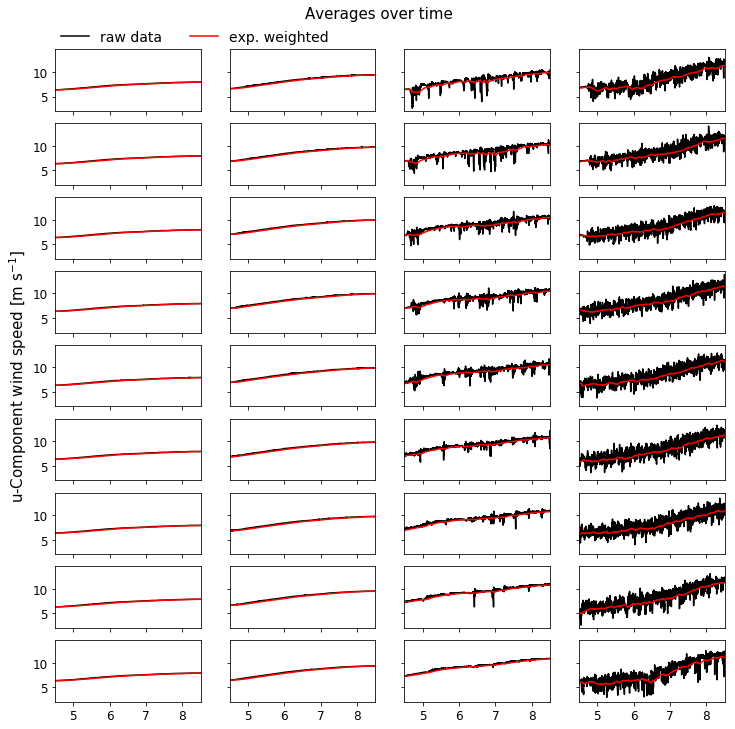

In [259]:
fig,ax = plt.subplots(nrows=ntwr, ncols=n_twrlines, figsize=(12,12),sharex=True,sharey=True)
for tl in range(0,n_twrlines):
    for tw in range(0,ntwr):
        ax[tw,tl].plot(time/3600.0,u[tl,tw,:],c='k',alpha=1.0,label='raw data')
        ax[tw,tl].plot(time/3600.0,avg_u_expT[tl,tw,:],c='r',alpha=1.0,label='exp. weighted')
        #ax[tw].set_ylim(7.0,8.0)
        ax[tw,tl].tick_params(labelsize=12)
        #ax[tw,tl].set_xlim(8.26,8.35)
        ax[tw,tl].set_xlim(min(time)/3600.0,max(time)/3600.0)
ax[4,0].set_ylabel('u-Component wind speed [m s$^{-1}$]',size=15)
ax[0,0].legend(frameon=False,ncol=3,fontsize=14,loc=(0.0,1.0))
plt.suptitle('Averages over time',size=15,y=0.93)
plt.show()

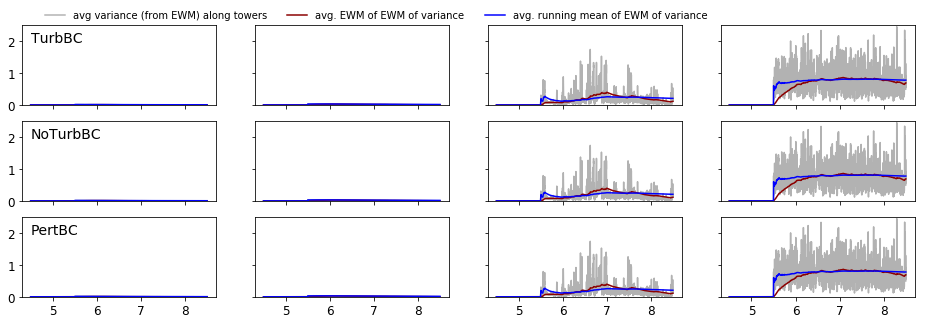

In [260]:
cc = 2
fig,ax = plt.subplots(nrows=ncases, ncols=4, sharey=True, sharex=True, figsize=(16,5))
for cc in range(0,ncases):
    for tl in range(0,n_twrlines):
        ax[cc,tl].plot(time/3600.0,np.mean(var_u_expT[tl,:,:],axis=0),c='k',alpha=0.3,
                    label='avg variance (from EWM) along towers')
        ax[cc,tl].plot(time/3600.0,np.mean(avg_var_u_expT[tl,:,:],axis=0),c='darkred',alpha=1.0,
                    label='avg. EWM of EWM of variance')
        ax[cc,tl].plot(time/3600.0,np.mean(avg_var_u_runexpT[tl,:,:],axis=0),c='blue',alpha=1.0,
                    label='avg. running mean of EWM of variance')
        ax[cc,tl].set_ylim(0,2.5)
        ax[cc,tl].tick_params(labelsize=12.0)
    ax[cc,0].text(4.5,2.3,cases[cc].replace('M2_D2_',''),ha='left',va='top',size=14)
    
ax[0,0].legend(frameon=False,ncol=4, loc=(0.1,1.01))
plt.show()

## Sparse sampling:

In [336]:
cc = 1
u = tsvarfull[varns.index('u'),cc,towerlines,:,5,:]
nt    = np.shape(u)[-1]


# --------------------------------- #
ts_int = 60
extract_times = np.arange(0,nt,ts_int)
nt = np.shape(extract_times)[0]
statistics_start_time = int(3600/ts_int)
# --------------------------------- #


window_len = 0.18
#alpha   = 70/(nt+1)
alpha = 1.0 - np.exp(-ts_int/400.0)
gam   = 0.0

alpha_2 = 12/(nt+1)

avg_u_expT = np.zeros((n_twrlines,ntwr,nt))
b_u_expT   = np.zeros((n_twrlines,ntwr,nt))

up_expT = np.zeros((n_twrlines,ntwr,nt))

var_u_expT = np.zeros((n_twrlines,ntwr,nt))

avg_var_u_expT = np.zeros((n_twrlines,ntwr,nt))
avg_var_u_runexpT = np.zeros((n_twrlines,ntwr,nt))


#nt = 5200


avg_u_expT[:,:,0] = u[:,:,0]


init_avg_stats = True
for tt in range(1,nt):
    #ext_t = extract_times[tt]
    #avg_u_expT[:,:,tt] = avg_u_expT[:,:,tt-1] + alpha*(u[:,:,ext_t]-avg_u_expT[:,:,tt-1])
    #if tt == 1: b_u_expT[:,:,0] = (1.0/3.0)*((u[:,:,1] - u[:,:,0]) + (u[:,:,2] - u[:,:,1]) + (u[:,:,3] - u[:,:,2]))
    if tt == 1: b_u_expT[:,:,0] = (u[:,:,1] - u[:,:,0])
    avg_u_expT[:,:,tt] = alpha*(u[:,:,tt]) +  (1.0 - alpha)*(avg_u_expT[:,:,tt-1] + b_u_expT[:,:,tt-1])    
    b_u_expT[:,:,tt] = gam*(avg_u_expT[:,:,tt] - avg_u_expT[:,:,tt-1]) + \
                (1.0 - gam)*b_u_expT[:,:,tt-1]

    if tt >= statistics_start_time:
        up_expT[:,:,tt] = u[:,:,ext_t]-avg_u_expT[:,:,tt-1]

        var_u_expT[:,:,tt] = up_expT[:,:,tt]**2

        if tt >= statistics_start_time+1:

            avg_var_u_expT[:,:,tt] = avg_var_u_expT[:,:,tt-1] + \
                                      alpha_2*(var_u_expT[:,:,tt]-avg_var_u_expT[:,:,tt-1])
            avg_var_u_runexpT[:,:,tt] = np.mean(var_u_expT[:,:,statistics_start_time:tt],axis=2)



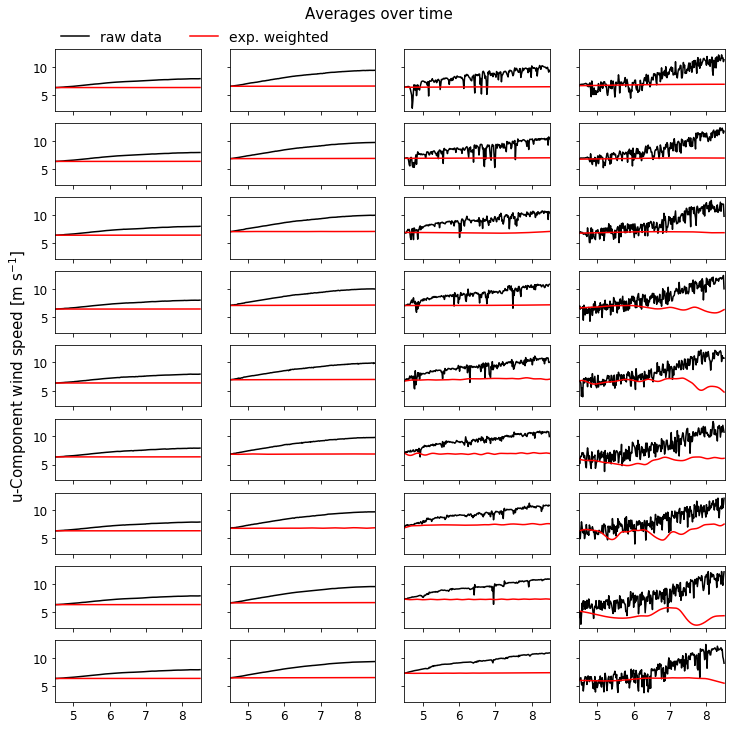

In [337]:
fig,ax = plt.subplots(nrows=ntwr, ncols=n_twrlines, figsize=(12,12),sharex=True,sharey=True)
for tl in range(0,n_twrlines):
    for tw in range(0,ntwr):
        ax[tw,tl].plot((extract_times+time[0])/3600.0,u[tl,tw,extract_times],c='k',alpha=1.0,label='raw data')
        ax[tw,tl].plot((extract_times+time[0])/3600.0,avg_u_expT[tl,tw,:],c='r',alpha=1.0,label='exp. weighted')
        ax[tw,tl].tick_params(labelsize=12)
        #ax[tw,tl].set_xlim(8.26,8.35)
        ax[tw,tl].set_xlim(min(time)/3600.0,max(time)/3600.0)
ax[4,0].set_ylabel('u-Component wind speed [m s$^{-1}$]',size=15)
ax[0,0].legend(frameon=False,ncol=3,fontsize=14,loc=(0.0,1.0))
plt.suptitle('Averages over time',size=15,y=0.93)
plt.show()

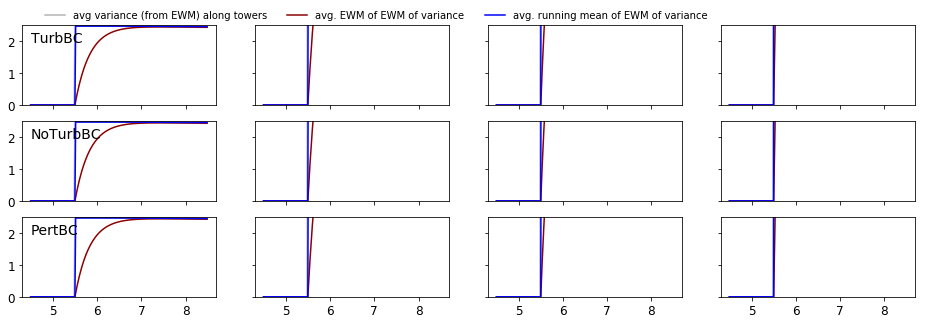

In [304]:
cc = 2
fig,ax = plt.subplots(nrows=ncases, ncols=4, sharey=True, sharex=True, figsize=(16,5))
for cc in range(0,ncases):
    for tl in range(0,n_twrlines):
        ax[cc,tl].plot((extract_times+time[0])/3600.0,np.mean(var_u_expT[tl,:,:],axis=0),c='k',alpha=0.3,
                    label='avg variance (from EWM) along towers')
        ax[cc,tl].plot((extract_times+time[0])/3600.0,np.mean(avg_var_u_expT[tl,:,:],axis=0),c='darkred',alpha=1.0,
                    label='avg. EWM of EWM of variance')
        ax[cc,tl].plot((extract_times+time[0])/3600.0,np.mean(avg_var_u_runexpT[tl,:,:],axis=0),c='blue',alpha=1.0,
                    label='avg. running mean of EWM of variance')
        ax[cc,tl].set_ylim(0,2.5)
        ax[cc,tl].tick_params(labelsize=12.0)
    ax[cc,0].text(4.5,2.3,cases[cc].replace('M2_D2_',''),ha='left',va='top',size=14)
    
ax[0,0].legend(frameon=False,ncol=4, loc=(0.1,1.01))
plt.show()

## Double Exponential Smoothing

In [348]:
statistics_start_time = 3600

cc = 1
u = tsvarfull[varns.index('u'),cc,towerlines,:,5,:]

nt    = np.shape(u)[-1]
window_len = 0.18
#alpha   = 70/(nt+1)
alpha = 1.0 - np.exp(-dt/400.0)
gam = 1.0 - np.exp(-dt/950.0)
#print(gam)
#wefwef
gam   = 0.001
alpha_2 = 12/(nt+1)


avg_u_expT = np.zeros((n_twrlines,ntwr,nt))
b_u_expT   = np.zeros((n_twrlines,ntwr,nt))
up_expT    = np.zeros((n_twrlines,ntwr,nt))
var_u_expT = np.zeros((n_twrlines,ntwr,nt))
avg_var_u_expT    = np.zeros((n_twrlines,ntwr,nt))
avg_var_u_runexpT = np.zeros((n_twrlines,ntwr,nt))

avg_u_expT[:,:,0] = u[:,:,0]
init_avg_stats = True
for tt in range(1,nt):
    if tt == 1: b_u_expT[:,:,0] = (1.0/3.0)*((u[:,:,1] - u[:,:,0]) + (u[:,:,2] - u[:,:,1]) + (u[:,:,3] - u[:,:,2]))
    avg_u_expT[:,:,tt] = alpha*(u[:,:,tt]) +  (1.0 - alpha)*(avg_u_expT[:,:,tt-1] + b_u_expT[:,:,tt-1])    
    b_u_expT[:,:,tt] = gam*(avg_u_expT[:,:,tt] - avg_u_expT[:,:,tt-1]) + \
                (1.0 - gam)*b_u_expT[:,:,tt-1]


    if tt >= statistics_start_time:
        up_expT[:,:,tt] = u[:,:,tt]-avg_u_expT[:,:,tt-1]

        var_u_expT[:,:,tt] = up_expT[:,:,tt]**2

        if tt >= statistics_start_time+1:

            avg_var_u_expT[:,:,tt] = avg_var_u_expT[:,:,tt-1] + \
                                      alpha_2*(var_u_expT[:,:,tt]-avg_var_u_expT[:,:,tt-1])
            avg_var_u_runexpT[:,:,tt] = np.mean(var_u_expT[:,:,statistics_start_time:tt],axis=2)



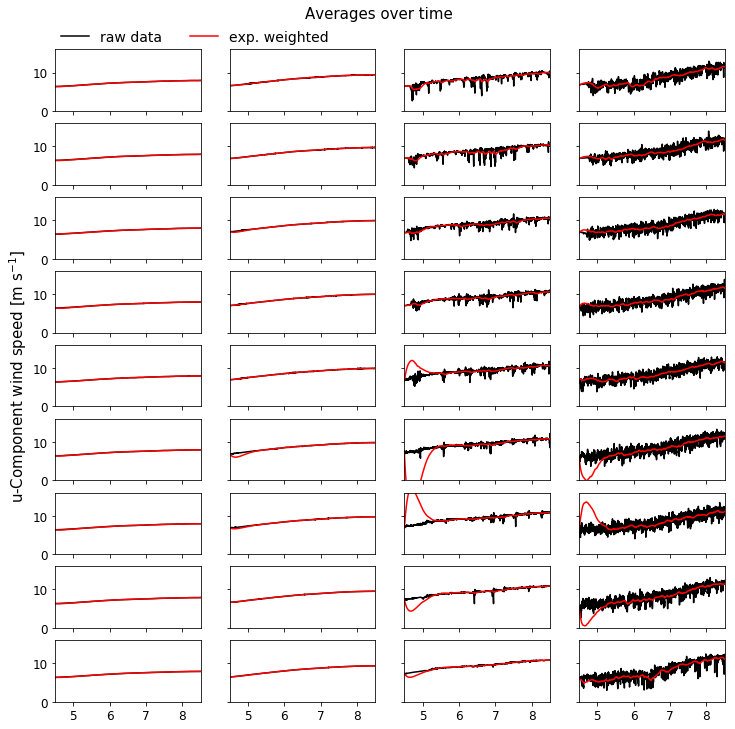

In [349]:
fig,ax = plt.subplots(nrows=ntwr, ncols=n_twrlines, figsize=(12,12),sharex=True,sharey=True)
for tl in range(0,n_twrlines):
    for tw in range(0,ntwr):
        ax[tw,tl].plot(time/3600.0,u[tl,tw,:],c='k',alpha=1.0,label='raw data')
        ax[tw,tl].plot(time/3600.0,avg_u_expT[tl,tw,:],c='r',alpha=1.0,label='exp. weighted')
        ax[tw,tl].set_ylim(0.0,16.0)
        ax[tw,tl].tick_params(labelsize=12)
        #ax[tw,tl].set_xlim(8.26,8.35)
        ax[tw,tl].set_xlim(min(time)/3600.0,max(time)/3600.0)
ax[4,0].set_ylabel('u-Component wind speed [m s$^{-1}$]',size=15)
ax[0,0].legend(frameon=False,ncol=3,fontsize=14,loc=(0.0,1.0))
plt.suptitle('Averages over time',size=15,y=0.93)
plt.show()

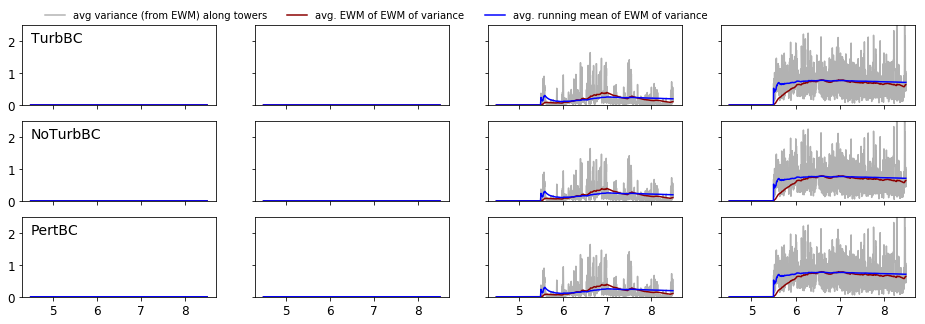

In [319]:
cc = 2
fig,ax = plt.subplots(nrows=ncases, ncols=4, sharey=True, sharex=True, figsize=(16,5))
for cc in range(0,ncases):
    for tl in range(0,n_twrlines):
        ax[cc,tl].plot(time/3600.0,np.mean(var_u_expT[tl,:,:],axis=0),c='k',alpha=0.3,
                    label='avg variance (from EWM) along towers')
        ax[cc,tl].plot(time/3600.0,np.mean(avg_var_u_expT[tl,:,:],axis=0),c='darkred',alpha=1.0,
                    label='avg. EWM of EWM of variance')
        ax[cc,tl].plot(time/3600.0,np.mean(avg_var_u_runexpT[tl,:,:],axis=0),c='blue',alpha=1.0,
                    label='avg. running mean of EWM of variance')
        ax[cc,tl].set_ylim(0,2.5)
        ax[cc,tl].tick_params(labelsize=12.0)
    ax[cc,0].text(4.5,2.3,cases[cc].replace('M2_D2_',''),ha='left',va='top',size=14)
    
ax[0,0].legend(frameon=False,ncol=4, loc=(0.1,1.01))
plt.show()

In [389]:
avgstart=0;avgend=-1
ntwrs=1

varns   = ['u','v','w','T','uAvg','vAvg','wAvg']
nvars   = np.shape(varns)[0]

In [390]:
initIndividualTowerVars = True
initAvgTowerVars        = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        fdir      = '/projects/mmc/NWTCRegion/{}/NWTC.run.{}/postProcessing/'.format(simstr[cc],cases[cc])
        pl        = 'probeLine{}'.format(twrs[tt])
        probeLine = sowfa.probeLine('{}{}/{}/'.format(fdir,pl,timedir),'y',['U','T','UAvg'])
        dt        = np.round(np.mean(probeLine.time[1:] - probeLine.time[:-1]),2)
        ntwr      = probeLine.ntowers; ntwrsq = int(np.sqrt(ntwr))
        if tt == 0: 
            tdz        = np.mean(probeLine.z[0,1:] - probeLine.z[0,:-1]) 
            twrheight  = probeLine.z[0,:] - probeLine.z[0,0] + tdz/2.0
            nz = np.shape(twrheight)[0]
        for vv in range(0,nvars):
            var = varns[vv]
            for tw in np.arange(0,probeLine.ntowers):
                if var == 'u':
                    pvar   = probeLine.u[tw,:,avgstart:avgend]
                elif var == 'v':
                    pvar   = probeLine.v[tw,:,avgstart:avgend]
                elif var == 'w':
                    pvar   = probeLine.w[tw,:,avgstart:avgend]
                    
                elif var == 'uAvg':
                    pvar   = probeLine.uAvg[tw,:,avgstart:avgend]
                elif var == 'vAvg':
                    pvar   = probeLine.vAvg[tw,:,avgstart:avgend]
                elif var == 'wAvg':
                    pvar   = probeLine.wAvg[tw,:,avgstart:avgend]
                    
                elif var == 'T':
                    pvar   = probeLine.T[tw,:,avgstart:avgend]
                    
                if initIndividualTowerVars == True:
                    print ("initializing individual tower vars")
                    time       = probeLine.time[avgstart:avgend] 
                    ntimes     = np.shape(time)[0]
                    tsvarfull  = np.zeros((nvars,ncases,ntwrs,ntwr,nz,ntimes))
                    initIndividualTowerVars = False
                tsvarfull[vv,cc,tt,tw,:,:]  = pvar
    print ('Done with case: {}'.format(cases[cc]))

initializing individual tower vars
Done with case: M2_SR_TurbBC


In [391]:
statistics_start_time = 3600

cc = 1
u = tsvarfull[varns.index('u'),0,0,:,5,:]

nt    = np.shape(u)[-1]
window_len = 0.18
#alpha   = 70/(nt+1)
alpha = 1.0 - np.exp(-dt/400.0)
gam = 1.0 - np.exp(-dt/950.0)
alpha_2 = 12/(nt+1)


avg_u_expT = np.zeros((ntwr,nt))
b_u_expT   = np.zeros((ntwr,nt))

avg_u_expT[:,0] = u[:,0]

init_avg_stats = True
for tt in range(1,nt):
#    avg_u_expT[:,tt] = avg_u_expT[:,tt-1] + alpha*(u[:,tt]-avg_u_expT[:,tt-1])


    if tt == 1: b_u_expT[:,0] = (1.0/3.0)*((u[:,1] - u[:,0]) + (u[:,2] - u[:,1]) + (u[:,3] - u[:,2]))
    avg_u_expT[:,tt] = alpha*(u[:,tt]) +  (1.0 - alpha)*(avg_u_expT[:,tt-1] + b_u_expT[:,tt-1])    
    b_u_expT[:,tt] = gam*(avg_u_expT[:,tt] - avg_u_expT[:,tt-1]) + \
                (1.0 - gam)*b_u_expT[:,tt-1]

#    if tt >= statistics_start_time:
#        up_expT[:,:,tt] = u[:,:,tt]-avg_u_expT[:,:,tt-1]
#
#        var_u_expT[:,:,tt] = up_expT[:,:,tt]**2
#
#        if tt >= statistics_start_time+1:
#
#            avg_var_u_expT[:,:,tt] = avg_var_u_expT[:,:,tt-1] + \
#                                      alpha_2*(var_u_expT[:,:,tt]-avg_var_u_expT[:,:,tt-1])
#            avg_var_u_runexpT[:,:,tt] = np.mean(var_u_expT[:,:,statistics_start_time:tt],axis=2)



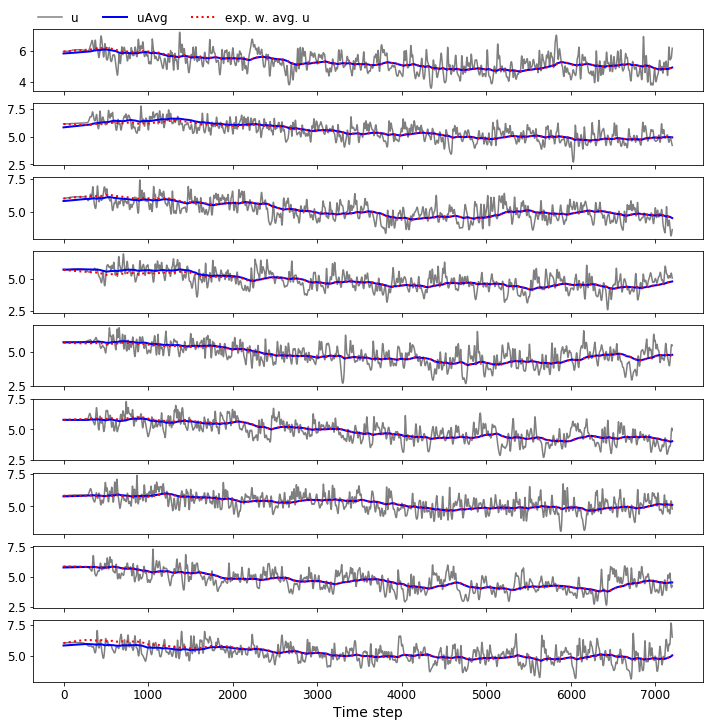

In [401]:
fig,ax = plt.subplots(nrows=9,sharex=True, figsize=(12,12))
for twn in range(0,9):
    ax[twn].plot(tsvarfull[0,0,0,twn,5,:],c='k',alpha=0.5,label='u')
    ax[twn].plot(tsvarfull[4,0,0,twn,5,:],c='b',lw=2.0,label='uAvg')
    ax[twn].plot(avg_u_expT[twn,:],c='r',ls=':',lw=2.0,label='exp. w. avg. u')
    #ax[twn].plot(u[twn,:])
    #ax[twn].set_xlim(3500,4000)
    ax[twn].tick_params(labelsize=12)
ax[0].legend(frameon=False,loc=(0,1),fontsize=12,ncol=3)
ax[-1].set_xlabel('Time step',size=14)
plt.show()